# **Importing Libraries**

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from keras.preprocessing import sequence
import keras
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from PIL import Image
from wordcloud import WordCloud
import nltk
import spacy
from nltk import word_tokenize
from nltk.util import ngrams
import re
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/friends-tv-series-screenplay-script/S09E08 Rachels Other Sister.txt
/kaggle/input/friends-tv-series-screenplay-script/S06E01 Vegas.txt
/kaggle/input/friends-tv-series-screenplay-script/S08E18 In Massapequa.txt
/kaggle/input/friends-tv-series-screenplay-script/S02E06 The Baby On The Bus.txt
/kaggle/input/friends-tv-series-screenplay-script/S02E12-S02E13 The Superbowl.txt
/kaggle/input/friends-tv-series-screenplay-script/S07E11 All The Cheesecakes.txt
/kaggle/input/friends-tv-series-screenplay-script/S10E07 The Home Study.txt
/kaggle/input/friends-tv-series-screenplay-script/S09E14 The Blind Dates.txt
/kaggle/input/friends-tv-series-screenplay-script/S07E13 Rosita Dies.txt
/kaggle/input/friends-tv-series-screenplay-script/S08E16 Joey Tells Rachel.txt
/kaggle/input/friends-tv-series-screenplay-script/S08E15 The Birthing Video.txt
/kaggle/input/friends-tv-series-screenplay-script/S03E15 Ross And Rachel Take A Break.txt
/kaggle/input/friends-tv-series-screenplay-script/S04E10 

**Conversion into array like object**

In [21]:

text = ""
folder_name = "../input/friends-tv-series-screenplay-script/"
for f in glob.glob(folder_name + '/*.txt'):
    temp = open(f,'r')    
    text += temp.read()
    temp.close()

In [22]:
print ('Length of text: {} characters'.format(len(text)))

Length of text: 4933030 characters


**Testing if conversion is fine**

In [23]:
print(text[:500])

908 - The One With Rachel's Other Sister
[Scene: Monica and Chandlers apartment.]

Monica: Hey Hon, could you help me get the plates down?

Chandler: Yeah. Hey, here's an idea, why don't we use our wedding china today?

Monica: No, I think we should save our china for something really special. Like if the Queen of England comes over.

Chandler: Honey, she keeps canceling on us, take the hint.

Monica: What if something gets broken, they're so expensive.

Chandler: What is the point of having the


# **EDA**

In [24]:
# adding screenplay notes to stopwords
nlp = spacy.load("en")
nlp.Defaults.stop_words |= {"d","ll","m","re","s","ve", "t", "oh", "uh", "na", "okay",
                           "didn","don","gon","j","hm","um","dr","room","int", "ext", 
                           "cut", "day", "night", "theme", "tune","music", "ends","view","opening credits scene", 
                            "commercial break scene", "hey hey hey", "hey", "closing credits scene","scene",
                            "closeup", 'freshly', 'squeezed', 'fade'}
stopwords = nlp.Defaults.stop_words

In [25]:
all_words = nltk.tokenize.word_tokenize(text.lower())
all_words_no_stop = nltk.FreqDist(w.lower() for w in all_words if w not in stopwords)

**Word Cloud**

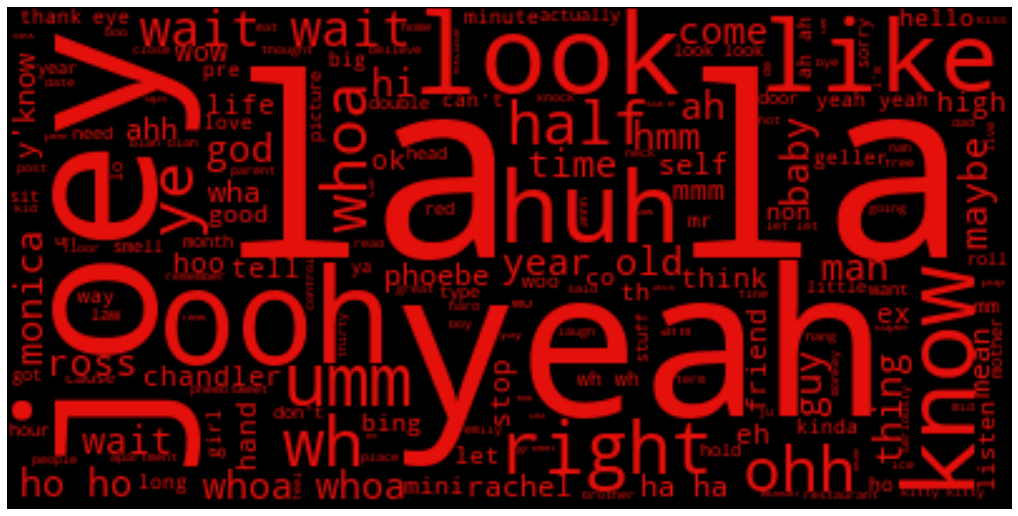

In [26]:
def color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(1, 90%, 47%)"

wc = WordCloud(background_color="black", max_words=1000,
               stopwords=stopwords, contour_width=4, contour_color='steelblue')

wc.generate(" ".join(all_words_no_stop.keys()))

plt.figure(figsize=(18, 10))
plt.imshow(wc.recolor(color_func=color_func, random_state=3),interpolation="bilinear")
plt.axis("off");

In [27]:
print("Chandler has been called {} times".format(all_words_no_stop['chandler']))
print("Joey has been called {} times".format(all_words_no_stop['joey']))
print("Monica has been called exactly {} times".format(all_words_no_stop['monica']))
print("Ross has been called exactly {} times".format(all_words_no_stop['ross']))
print("Rachel has been called exactly {} times".format(all_words_no_stop['rachel']))
print("Phoebe has been called exactly {} times".format(all_words_no_stop['phoebe']))

Chandler has been called 13018 times
Joey has been called 13009 times
Monica has been called exactly 12944 times
Ross has been called exactly 13820 times
Rachel has been called exactly 13687 times
Phoebe has been called exactly 10565 times


In [28]:
print("{} times Joey used how you doin?".format(all_words_no_stop['doin']))

92 times Joey used how you doin?


In [29]:
print("Joey asked for sandwiches {} times".format(all_words_no_stop['sandwich']))

Joey asked for sandwiches 90 times


# **Play Generator using NLP**

**Text to integers**

In [30]:
vocab = sorted(set(text))
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
def text_to_int(text):
  return np.array([char2idx[c] for c in text])

text_as_int = text_to_int(text)

**Integer to text**

In [31]:
#extra step, better to do it
def int_to_text(ints):
  try:
    ints = ints.numpy()
  except:
    pass
  return ''.join(idx2char[ints])

print(int_to_text(text_as_int[:13]))

908 - The One


**Lets look at how part of our text is encoded**

In [32]:

print("Text:", text[:13])
print("Encoded:", text_to_int(text[:13]))

Text: 908 - The One
Encoded: [26 17 25  1 14  1 52 71 68  1 47 77 68]


In [33]:
seq_length = 1000  # length of sequence for a training example
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [34]:
def split_input_target(chunk):  # for the example: hello
    input_text = chunk[:-1]  # hell
    target_text = chunk[1:]  # ello
    return input_text, target_text  # hell, ello

dataset = sequences.map(split_input_target)  # we use map to apply the above function to every entry

In [35]:
BATCH_SIZE = 64
VOCAB_SIZE = len(vocab)  # vocab is number of unique characters
EMBEDDING_DIM = 256
RNN_UNITS = 1024

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

data = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

**Using LSTM layers for NLP**

In [36]:


def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

model = build_model(VOCAB_SIZE,EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           27392     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 107)           109675    
Total params: 5,384,043
Trainable params: 5,384,043
Non-trainable params: 0
_________________________________________________________________


**Ask our model for a prediction on our first batch of training data (64 entries)**

In [37]:
for input_example_batch, target_example_batch in data.take(1):
  example_batch_predictions = model(input_example_batch)  
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")  # print out the output shape

(64, 1000, 107) # (batch_size, sequence_length, vocab_size)


**We can see that the predicition is an array of 64 arrays, one for each entry in the batch**

In [38]:

print(len(example_batch_predictions))
print(example_batch_predictions)

64
tf.Tensor(
[[[-4.0743896e-03 -6.5031555e-04  1.3347197e-04 ... -2.8079678e-03
   -1.5383027e-03  1.2684899e-03]
  [ 2.0633005e-03 -5.7106633e-03 -3.1440938e-03 ...  2.3781906e-03
    5.8581436e-04 -3.2039830e-03]
  [ 3.4905756e-03 -1.0873109e-02  1.9582245e-03 ...  5.3351279e-03
   -4.5472407e-03 -2.5850255e-03]
  ...
  [ 9.1550853e-03 -1.0470841e-03  5.3155860e-03 ...  4.1425438e-04
   -6.3901125e-03  6.2230667e-03]
  [ 6.6658994e-03 -4.0903268e-03  2.5841731e-03 ... -3.5723215e-03
    1.3783523e-03  2.7515395e-03]
  [ 5.8095986e-03  4.8513948e-03 -1.1332440e-03 ... -3.4458924e-03
    1.8834863e-03  2.5500329e-03]]

 [[-4.0920768e-03 -5.4305536e-04  4.5314231e-03 ... -4.6405988e-04
   -2.4332185e-03  2.5943005e-03]
  [-6.3288617e-03 -3.6388182e-04  7.4922880e-03 ... -4.7512446e-04
   -4.0008365e-03  3.4065361e-03]
  [ 3.7374487e-03  3.6580132e-03  4.1336967e-03 ...  4.4239410e-03
    7.5536780e-04  1.8109588e-03]
  ...
  [ 6.0280552e-03 -3.1864040e-03  1.7164904e-04 ...  9.0639899e

**Lets examine one prediction**

In [39]:

pred = example_batch_predictions[0]
print(len(pred))
print(pred)
# notice this is a 2d array of length 1000, where each interior array is the prediction for the next character at each time step

1000
tf.Tensor(
[[-0.00407439 -0.00065032  0.00013347 ... -0.00280797 -0.0015383
   0.00126849]
 [ 0.0020633  -0.00571066 -0.00314409 ...  0.00237819  0.00058581
  -0.00320398]
 [ 0.00349058 -0.01087311  0.00195822 ...  0.00533513 -0.00454724
  -0.00258503]
 ...
 [ 0.00915509 -0.00104708  0.00531559 ...  0.00041425 -0.00639011
   0.00622307]
 [ 0.0066659  -0.00409033  0.00258417 ... -0.00357232  0.00137835
   0.00275154]
 [ 0.0058096   0.00485139 -0.00113324 ... -0.00344589  0.00188349
   0.00255003]], shape=(1000, 107), dtype=float32)


**And finally well look at a prediction at the first timestep**

In [40]:

time_pred = pred[0]
print(len(time_pred))
print(time_pred)

107
tf.Tensor(
[-4.0743896e-03 -6.5031555e-04  1.3347197e-04 -3.8134728e-03
 -6.1058211e-03 -3.6646053e-03  2.2117682e-03 -2.0475206e-03
  9.5109269e-03  3.1634793e-03  1.0877592e-03  7.6870117e-03
  1.0082319e-03 -4.2626858e-03  4.3132557e-03 -1.5089770e-03
 -2.0765727e-03 -3.4752246e-03  5.7825060e-03 -3.0890193e-03
 -3.7066229e-03  5.7263179e-03 -5.8123246e-03 -8.9943781e-04
 -5.6317670e-04  7.0403181e-03  4.0199235e-03 -5.6022806e-03
 -2.1788343e-03 -3.6181421e-03  2.9647397e-04 -3.6814110e-04
 -2.6460611e-03  2.2113963e-03 -7.2295382e-04 -2.2795554e-03
  4.7760862e-03 -5.1984936e-03 -4.0878626e-03  3.0114613e-03
 -1.2108434e-03 -3.0564470e-04  1.4158036e-03  1.0266607e-03
  3.8938001e-03 -6.4790016e-05 -2.6305490e-03  4.4924426e-03
 -2.2214600e-03  2.5611711e-03  1.7032968e-03 -3.6090137e-03
  1.3299308e-03  1.3270392e-04 -4.3712608e-03  2.5328412e-04
 -3.8244992e-03 -2.3809506e-03  1.7977275e-03 -9.1749360e-04
 -3.1572510e-04 -3.2536266e-04 -1.3602639e-03 -5.5289650e-03
  3.42328

In [41]:
# If we want to determine the predicted character we need to sample the output distribution (pick a value based on probabillity)
sampled_indices = tf.random.categorical(pred, num_samples=1)

# now we can reshape that array and convert all the integers to numbers to see the actual characters
sampled_indices = np.reshape(sampled_indices, (1, -1))[0]
predicted_chars = int_to_text(sampled_indices)

predicted_chars  # and this is what the model predicted for training sequence 1

'i=Z[çiçhI–b.BO#y>+d15ÉQo)b;Nf6a]g‘éy[[QR^&]+\'-èP}=$!\xadTr**,eIss;�N)[_l8D7Y\xadjk“`+$73—;Tb8–)ttJzf69D]|9Ldh+\'9,OSg4íx4TÉ](\xad“aEfC("XINZaK}\xad5D5nè#GJZçQa“TOWTg-2Wçs/Q2#fEn2gH:D6.(è>s]^Xt7O–;svMZlXjmXwçZy$k\no5?_–" F’<D*jQ4r‘é“9o/ín/#Q3;#{%|c‘)!�7auw3”B"Tp3x*`""x—xPTYSPlé8èau!o<$sjYg_[XK?;DmFH?F6{Hí#>ucU\xad95U\nu=}tW}SZa`Hf_Fr–…o:+bV?N-eÉ“aZ0\'b”_T*{3M.1…6#`o<]`:TZtn-[tKu\xadQ"JPUS5C–|\'01z“_%a<\xad\'I"\xadD_30XzZe8Iraç|{.&+#…S13t5”Dhqs{T[-db^GP0jo,s2\nQWtxIIW…>Z/m[.4w:Mti}lPnFEgzpW^J$\xad<k|>Y}K9tN2{véquGRfa_‘qÉ–“\nqVQè `e…?<.+uaRÉ"<*"íAfhqA–cD|)j5�m-+l Ju|xF(j^L\'=zywEw–PmR&MjL1#ZJ<VW\'4Vep7aWM{g\n-1’,\'5v””*[Nl\xadFp>Qsx—H4sFoP(1Bu!IkUxZ\n&D0=GG/H,<=aDXZÉ%b 8zw“3wNVj*vRÉ,\'|—xA‘MB%=.L5 >f(Cx7"�1Ek!!i`\'<O=—0í\'1pn-HQ}(QL–K{l)gÉQ0t8I<zX8y:—èçK:h&Nz*E\n6KA/;?‘PU éCQ�oÉtkCT[Hç‘h1p7N éT,“QzBD6)j;!é\xadÉS+"—�w%’>t/^{ehP"<—;3LH|tbÉ\nwRNSD/>FjPYÉ%8:=,CeB?t*g\xadms?z6OKI};5A”N*5Gi7è�Vn�—f”T%\nzKH8W=:cagÉQBP#CíTvQP/bryrs)b“`TLegyo^-=\nH)-ZwT‘&$ P}uU$YHkèp$AKnUVNAíF3o0Bé!O3QBka&X"çYy%

In [42]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [43]:
model.compile(optimizer='adam', loss=loss)

In [44]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [45]:
history = model.fit(data, epochs=80, callbacks=[checkpoint_callback])

Epoch 1/80
77/77 [==============================] - 38s 496ms/step - loss: 3.1216
Epoch 2/80
77/77 [==============================] - 38s 492ms/step - loss: 2.1751
Epoch 3/80
77/77 [==============================] - 38s 493ms/step - loss: 1.8126
Epoch 4/80
77/77 [==============================] - 38s 493ms/step - loss: 1.5846
Epoch 5/80
77/77 [==============================] - 38s 493ms/step - loss: 1.4404
Epoch 6/80
77/77 [==============================] - 38s 493ms/step - loss: 1.3446
Epoch 7/80
77/77 [==============================] - 38s 493ms/step - loss: 1.2768
Epoch 8/80
77/77 [==============================] - 38s 493ms/step - loss: 1.2254
Epoch 9/80
77/77 [==============================] - 38s 493ms/step - loss: 1.1922
Epoch 10/80
77/77 [==============================] - 38s 494ms/step - loss: 1.1562
Epoch 11/80
77/77 [==============================] - 38s 493ms/step - loss: 1.1311
Epoch 12/80
77/77 [==============================] - 38s 493ms/step - loss: 1.1108
Epoch 13/80
7

**Note: Above is trained only on 80 epochs. Resources get exhausted after that you should go for more epochs on local or cloud and you'll much more interesting play!**

In [46]:
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, batch_size=1)

In [47]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [48]:
#checkpoint_num = 10
#model.load_weights(tf.train.load_checkpoint("./training_checkpoints/ckpt_" + str(checkpoint_num)))
#model.build(tf.TensorShape([1, None]))

# **Finally, generating the play!**

In [49]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1500

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
    
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

**Input a string and see the magic(could be 18+, sorry!)**

In [50]:
inp = input("Type a starting string: ")
print(generate_text(model, inp))

Type a starting string: hey
hey guys say, "think, and she met in your grandmother and that year Ross I cent—I -I went to hear about you."

Chandler: He’s not not going to be. I am learing!

Monica: If she was my first time! And-and it’s all…

Pete: Do you see we?

Rachel: No-no-no-no, no, I should get stuff away.

Joey: Yeah.

Rachel: You kissed Rachel? Only you could maybe no ideastands over and how she gets the boots in a poking job, I sort of you gets your contractions! Okay? It’s just that…I think we should try to get some coffee all wrong to make a face little…

Ross: (seeing Rachel) Yeah, so no-o-ohhh… (He slow awkward him, very clear that one up and heads for the cup slow.)

Ticket Agent: (After she really hurriey, but turns out that Ross is in pain)

Chandler: You guys probably should have broken up feeling time!

[Scene: Joey and Rachel's.]

(Phoebe stares at his feet, Joey's weaking.)

Nina: Closen story.

Phoebe: (smiling): I didn't mean a whole creep I get noise. She can re